# Introduction
In this dataset, each entry is a listing. Listing includes all the information for a specific customer.

Questions: 
* Is there any Seasonality in the Amount of the loan?
* How does the length of the loan (Term) affect the lenders Estimated Return?
* Does being a homeowner affect the amount people tend to borrow?
* How does the length of the loan (Term) affect the Borrower’s Annual Percentage Rate (APR)?
* Does the borrower’s stated monthly income (StatedMonthlyIncome), show any relationship to whether the borrower indicated they have the required documentation to support their income (IncomeVerifiable)?
* Does the borrowers APR and monthy payment relate to where a person is more likely to default on the loan?
* How does the interest rate for student borrowers relate to non-student borrowers?
* Does the state the borrower lives in, give any information whether they will default?

In [356]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

%matplotlib inline

In [167]:
df = pd.read_csv('prosperLoanData.csv')

In [168]:
df.head()

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20


In [169]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  EstimatedLoss

In [170]:
def check_dtype(column):
    # check if convert float to int
    # if return true, means the dtype can be converted to int.
    convert = df[column].fillna(0).astype('int64').astype('float')
    if sum(df[column].fillna(0) - convert) == 0.0:
        print(column + ': Data type should be int')
    else: print(column + ': Keep the present data type')

In [171]:
check_column = ['CurrentCreditLines', 'OpenCreditLines','TotalCreditLinespast7years','InquiriesLast6Months', 'TotalInquiries','CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years', 'PublicRecordsLast10Years','PublicRecordsLast12Months','RevolvingCreditBalance','AvailableBankcardCredit','TotalTrades','TradesOpenedLast6Months','TotalProsperLoans','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ScorexChangeAtTimeOfListing','LoanFirstDefaultedCycleNumber']
for column in check_column:
    check_dtype(column)

CurrentCreditLines: Data type should be int
OpenCreditLines: Data type should be int
TotalCreditLinespast7years: Data type should be int
InquiriesLast6Months: Data type should be int
TotalInquiries: Data type should be int
CurrentDelinquencies: Data type should be int
AmountDelinquent: Data type should be int
DelinquenciesLast7Years: Data type should be int
PublicRecordsLast10Years: Data type should be int
PublicRecordsLast12Months: Data type should be int
RevolvingCreditBalance: Data type should be int
AvailableBankcardCredit: Data type should be int
TotalTrades: Data type should be int
TradesOpenedLast6Months: Data type should be int
TotalProsperLoans: Data type should be int
OnTimeProsperPayments: Data type should be int
ProsperPaymentsLessThanOneMonthLate: Data type should be int
ProsperPaymentsOneMonthPlusLate: Data type should be int
ScorexChangeAtTimeOfListing: Data type should be int
LoanFirstDefaultedCycleNumber: Data type should be int


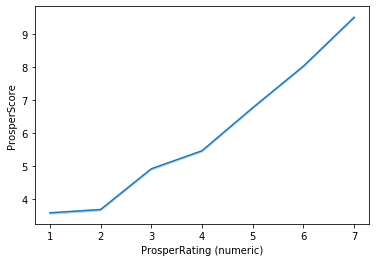

In [172]:
# check if the prosperating and prosperscore are repetitive
test = df[['ProsperRating (numeric)','ProsperScore']]
sns.lineplot(x = 'ProsperRating (numeric)', y = 'ProsperScore', data = test)
#sns.boxplot(data = test);

# Data Wrangling
### Quality issues
* ListingKey and ListingNumbers are repetitive in terms of identification of listing
* Erroneous Dtype:
    * Date: `ListingCreationDate`,`ClosedDate`,`ListingCategory (numeric)`,`DateCreditPulled`,`FirstRecordedCreditLine`,`LoanOriginationDate`
    
    * float to int: `CurrentCreditLines`, `OpenCreditLines`,`TotalCreditLinespast7years`,`InquiriesLast6Months`, `TotalInquiries`,`CurrentDelinquencies`,`AmountDelinquent`,`DelinquenciesLast7Years`, `PublicRecordsLast10Years`,`PublicRecordsLast12Months`,`RevolvingCreditBalance`,`AvailableBankcardCredit`,`TotalTrades`,`TradesOpenedLast6Months`,`TotalProsperLoans`,`OnTimeProsperPayments`,`ProsperPaymentsLessThanOneMonthLate`,`ProsperPaymentsOneMonthPlusLate`,`ScorexChangeAtTimeOfListing`,`LoanFirstDefaultedCycleNumber`
    * IncomeRange: "$0" and "Not Employed" are repetitive.

### Tidiness issues:

* repetitive: ProsperRating (numeric), ProsperRating (Alpha)
* LoanOriginationQuarter

In [173]:
col_to_date = ['ListingCreationDate','ClosedDate','DateCreditPulled','FirstRecordedCreditLine','LoanOriginationDate']
for column in col_to_date:
    df[column] = pd.to_datetime(df[column])

In [174]:
df[col_to_date].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 5 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ListingCreationDate      113937 non-null  datetime64[ns]
 1   ClosedDate               55089 non-null   datetime64[ns]
 2   DateCreditPulled         113937 non-null  datetime64[ns]
 3   FirstRecordedCreditLine  113240 non-null  datetime64[ns]
 4   LoanOriginationDate      113937 non-null  datetime64[ns]
dtypes: datetime64[ns](5)
memory usage: 4.3 MB


In [175]:
col_to_int = ['CurrentCreditLines', 'OpenCreditLines','TotalCreditLinespast7years','InquiriesLast6Months', 'TotalInquiries','CurrentDelinquencies','AmountDelinquent','DelinquenciesLast7Years', 'PublicRecordsLast10Years','PublicRecordsLast12Months','RevolvingCreditBalance','AvailableBankcardCredit','TotalTrades','TradesOpenedLast6Months','TotalProsperLoans','OnTimeProsperPayments','ProsperPaymentsLessThanOneMonthLate','ProsperPaymentsOneMonthPlusLate','ScorexChangeAtTimeOfListing','LoanFirstDefaultedCycleNumber']
for column in col_to_int:
    df[column] = df[column].fillna(0).astype('int64')

In [176]:
df[col_to_int].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 20 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   CurrentCreditLines                   113937 non-null  int64
 1   OpenCreditLines                      113937 non-null  int64
 2   TotalCreditLinespast7years           113937 non-null  int64
 3   InquiriesLast6Months                 113937 non-null  int64
 4   TotalInquiries                       113937 non-null  int64
 5   CurrentDelinquencies                 113937 non-null  int64
 6   AmountDelinquent                     113937 non-null  int64
 7   DelinquenciesLast7Years              113937 non-null  int64
 8   PublicRecordsLast10Years             113937 non-null  int64
 9   PublicRecordsLast12Months            113937 non-null  int64
 10  RevolvingCreditBalance               113937 non-null  int64
 11  AvailableBankcardCredit              11

In [177]:
df.replace({'IncomeRange': {"Not employed": "$0"}},inplace=True)
df.IncomeRange.value_counts()

$25,000-49,999    32192
$50,000-74,999    31050
$100,000+         17337
$75,000-99,999    16916
Not displayed      7741
$1-24,999          7274
$0                 1427
Name: IncomeRange, dtype: int64

In [178]:
col_drop=['ProsperRating (numeric)']
df.drop(columns = col_drop, inplace= True)

In [190]:
df.shape

(113937, 80)

In [181]:
df.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

#### Is there any Seasonality in the Amount of the loan?

In [317]:
sub_df = df[['LoanOriginalAmount','LoanOriginationDate']]
sub_df_agg = sub_df.groupby('LoanOriginationDate')['LoanOriginalAmount'].sum()
sub_df_agg.rename("LoanOriginalAmount")

LoanOriginationDate
2005-11-15       1000
2005-11-18       1000
2005-11-22       4500
2005-11-23       1000
2005-11-25      19800
               ...   
2014-03-06    3111922
2014-03-07    3167860
2014-03-10    3106201
2014-03-11    3367250
2014-03-12     402375
Name: LoanOriginalAmount, Length: 1873, dtype: int64

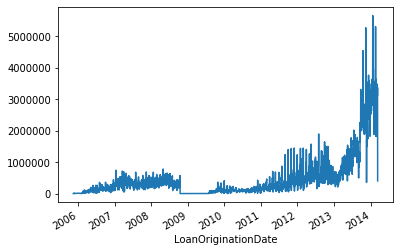

In [318]:
sub_df_agg.plot.line(x = 'LoanOriginationDate',y = sub_df_agg.values);


In [294]:
sub_df = df[['LoanOriginalAmount','LoanOriginationDate']]
sub_df = sub_df.set_index('LoanOriginationDate')
sub_df_agg = sub_df.groupby('LoanOriginationDate')['LoanOriginalAmount'].sum()
y = sub_df_agg.resample('M').sum()

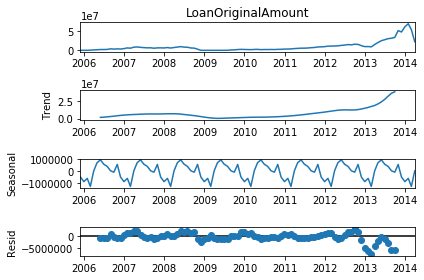

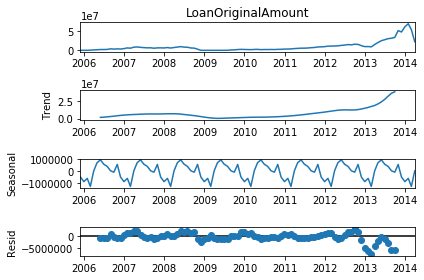

In [291]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()

0        2014-03-12
1        2014-03-12
2        2014-03-12
3        2014-03-12
4        2014-03-12
            ...    
113932   2005-11-23
113933   2005-11-22
113934   2005-11-22
113935   2005-11-18
113936   2005-11-15
Name: LoanOriginationDate, Length: 113937, dtype: datetime64[ns]

In [243]:
result = seasonal_decompose(sub_df, model='additive')
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

TypeError: float() argument must be a string or a number, not 'Timestamp'

#### How does the length of the loan (Term) affect the lenders Estimated Return?

According to the dataset, the lenders estimated return only applicable for loans originated after July 2009.

In [382]:
sub_df = df[['EstimatedReturn','BorrowerAPR','Term']]

In [383]:
sub_df.dropna(axis=0,inplace=True)
sub_df.shape

D:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(84853, 3)

In [384]:
sub_df.Term.value_counts()
sub_df.replace({'Term':{60:'5_year',36:'3_year',12:'1_year'}},inplace=True)

D:\anaconda3\lib\site-packages\pandas\core\generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [385]:
sub_df.groupby('Term')['EstimatedReturn'].describe()

,count,mean,std,min,25%,50%,75%,max
Term,,,,,,,,
1_year,1613.0,0.060680,0.025066,0.0146,0.04200,0.05630,0.0682,0.1270
3_year,58695.0,0.094762,0.031148,-0.1827,0.07192,0.09211,0.1150,0.2837
5_year,24545.0,0.101517,0.026798,0.0463,0.08027,0.09414,0.1214,0.1755


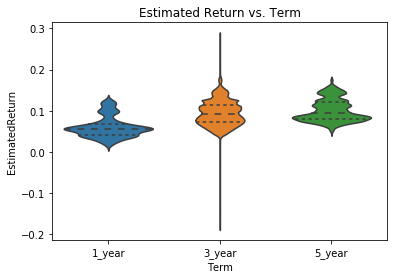

In [389]:
sns.violinplot(x='Term',y='EstimatedReturn',data=sub_df,inner='quartile', order=["1_year", "3_year", "5_year"])
plt.title('Estimated Return vs. Term');

For 1-year term loan, the expected return is 6.08%. Whilreas for the 3-year term loan, the lender can expected a 9.4% return. The highest expected return belongs to 5-year term loan which is 10.2%. Among all three kinds of loan, the 3-year term has a rather high variance while 1-year term loan and 5-year term loan are more stable.In conclusion, longer term are more likely to recieve a higher estimated return. Therefore the investor should considering to offer more 5-year term loans for client if possible.

#### Does being a homeowner affect the amount people borrow?

Hypothesis, being a homeowner does not affect the amount people borrow. I use $\mu_0$ to present the average loan origincal amount for non-homeowner and 

$\mu_0 = \mu_1$

#### Does the borrowers APR and monthy payment relate to where a person is more likely to default on the loan?